# How to use Fireworks Algorithm in classifying soybean dataset in Python

The soybean dataset has 14 types of leafs. Each one class have minimum 10 types of images and some have 50 images. the total images are 375 images. in the test folder we have 41 images. with this we have to train 375 images with class labels and test on 41 images, predict each image class label.

### https://github.com/cilatpku/firework-algorithm

In [ ]:
!pip install pmlb

In [1]:
# imports
from pmlb import fetch_data
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
import tensorflow.keras.layers as Layers
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D, Activation, BatchNormalization
from tensorflow.keras.utils import to_categorical

### *Loading Dataset*

In [2]:
# loading dataset
dataset_name = 'soybean'
dataset = fetch_data(dataset_name)
print(dataset.head())

print("\n", dataset.columns)

cols = ['date', 'plant-stand', 'precip', 'temp', 'hail', 'crop-hist',
       'area-damaged', 'severity', 'seed-tmt', 'germination', 'plant-growth',
       'leaves', 'leafspots-halo', 'leafspots-marg', 'leafspot-size',
       'leaf-shread', 'leaf-malf', 'leaf-mild', 'stem', 'lodging',
       'stem-cankers', 'canker-lesion', 'fruiting-bodies', 'external-decay',
       'mycelium', 'int-discolor', 'sclerotia', 'fruit-pods', 'fruit-spots',
       'seed', 'mold-growth', 'seed-discolor', 'seed-size', 'shriveling',
       'roots', 'target']

print(dataset[cols].info())
print(dataset[cols].describe())
print(dataset[cols].corr())

   date  plant-stand  precip  temp  hail  crop-hist  area-damaged  severity  \
0     6            2       1     3     2          4             1         2   
1     2            2       1     3     2          3             2         3   
2     3            2       1     3     2          4             2         3   
3     3            2       1     3     2          4             2         3   
4     6            2       1     3     2          3             2         2   

   seed-tmt  germination  ...  sclerotia  fruit-pods  fruit-spots  seed  \
0         2            1  ...          1           4            4     2   
1         1            0  ...          1           4            4     2   
2         1            3  ...          1           4            4     2   
3         2            0  ...          1           4            4     2   
4         2            3  ...          1           4            4     2   

   mold-growth  seed-discolor  seed-size  shriveling  roots  target  
0   

### *Handling and Spliting Data*

In [3]:
# loading features and targets from dataset
X, y = fetch_data(dataset_name, return_X_y=True)

# split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# Normalizing dataset
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# One-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

### *Creating Model*

In [4]:
# create Model
model = Sequential()
model.add(Dense(units = 56, input_dim=35, activation="relu"))
model.add(Dense(units = 28, activation="relu"))
model.add(Dense(units = 19, activation="softmax"))

# **<u>Creating Custom Optimizer**

In [5]:
from tensorflow.keras.optimizers import Adam

# This class defines the API to add Ops to train a model. 
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import state_ops
from tensorflow.python.framework import ops
from tensorflow.python.training import optimizer
import tensorflow as tf

In [6]:
# https://github.com/cilatpku/firework-algorithm/blob/master/fwa/BBFWA.py
class Firework(optimizer.Optimizer):
  def __init__(self,
                # params for prob
                evaluator = None,
                dim = 2,
                upper_bound = 100,
                lower_bound = -100,
                max_iter = 10000,
                max_eval = 20000,
                # params for method
                sp_size = 200,
                init_amp = 200, 
                name="Firework", use_locking=False, **kwargs):
    super(Firework, self).__init__(use_locking, name)

    ## Parameters

    # params of method
    self.sp_size = sp_size       # total spark size
    self.init_amp = init_amp     # initial dynamic amplitude

    # load params
    self.evaluator = evaluator
    self.dim = dim
    self.upper_bound = upper_bound
    self.lower_bound = lower_bound

    self.max_iter = max_iter
    self.max_eval = max_eval


    ## States

    # private init states
    self._num_iter = 0
    self._num_eval = 0
    self._dyn_amp = init_amp

    # public states
    self.best_idv = None    # best individual found
    self.best_fit = None    # best fitness found
    self.trace = []         # trace of best individual in each generation

    ## Fireworks
    self.fireworks = np.random.uniform(self.lower_bound, self.upper_bound, [1, self.dim])
    self.fireworks = self.fireworks.tolist()
    self.fits = self.evaluator(self.fireworks)

    ## Tensor versions of the constructor arguments, created in _prepare().
    self.dim_t = None
    self.upper_bound_t = None
    self.lower_bound_t = None
    self.max_iter_t = None
    self.max_eval_t = None
    self.sp_size_t = None
    self.init_amp_t = None

    self.fireworks_t = None
    self.fits_t = None

  def _create_slots(self, var_list):
    """For each model variable, create the optimizer variable associated with it.
        TensorFlow calls these optimizer variables "slots"."""
    # Create slots for the first and second moments.
    for v in var_list:
        self._zeros_slot(v, "fireworks", self._name)
    for v in var_list:
        self._zeros_slot(v, "fits", self._name)

  def _prepare(self):
    # self.evaluator_t = ops.convert_to_tensor(self.evaluator, name="evaloator")
    self.dim_t = ops.convert_to_tensor(self.dim, name="dimention")
    self.upper_bound_t = ops.convert_to_tensor(self.upper_bound, name="upper_bound")
    self.lower_bound_t = ops.convert_to_tensor(self.lower_bound, name="lower_bound")
    self.max_iter_t = ops.convert_to_tensor(self.max_iter, name="max_iterations")
    self.max_eval_t = ops.convert_to_tensor(self.max_eval, name="max_eval")
    self.sp_size_t = ops.convert_to_tensor(self.sp_size, name="sp_size")
    self.init_amp_t = ops.convert_to_tensor(self.init_amp, name="init_amp")

    self.fireworks_t = ops.convert_to_tensor(self.fireworks, name="fireworks")
    self.fits_t = ops.convert_to_tensor(self.fits, name="fits")

    # print(self.fireworks_t)

  def _resource_apply_dense(self, grad, var):
    evaluator = self.evaluator
    dim_t = math_ops.cast(self.dim_t, var.dtype.base_dtype)
    upper_bound_t = math_ops.cast(self.upper_bound_t, var.dtype.base_dtype)
    lower_bound_t = math_ops.cast(self.lower_bound_t, var.dtype.base_dtype)
    max_iter_t = math_ops.cast(self.max_iter_t, var.dtype.base_dtype)
    max_eval_t = math_ops.cast(self.max_eval_t, var.dtype.base_dtype)
    sp_size_t = math_ops.cast(self.sp_size_t, var.dtype.base_dtype)
    init_amp_t = math_ops.cast(self.init_amp_t, var.dtype.base_dtype)

    fits = self.get_slot(grad, "fits")
    fireworks = self.get_slot(var, "fireworks")

    fireworks_update, fits_update = self.iter(self.fireworks, self.fits)
    
    self.fireworks = fireworks_update
    self.fits = fits_update

    fireworks_update_t = math_ops.cast(fireworks_update, var.dtype.base_dtype)
    fits_update_t = math_ops.cast(fits_update, var.dtype.base_dtype)

    self.fireworks_t = fireworks_update_t
    self.fits_t = fits_update_t
    
    # print("fireworks_update : ", fireworks_update)
    # print("fits_update : ", fits_update)

    #Create an op that groups multiple operations
    #When this op finishes, all ops in input have finished
    return control_flow_ops.group(*[fits_update_t, fireworks_update_t])

  ## Helper functions
  def iter(self, fireworks, fits):

    #   print("...\n")
      
      e_sparks, e_fits = self._explode(fireworks, fits)
        
      n_fireworks, n_fits = self._select(fireworks, fits, e_sparks, e_fits)    

      # update states
      if n_fits[0] < fits[0]:
          self._dyn_amp *= 1.2
      else:
          self._dyn_amp *= 0.9

      self._num_iter += 1
      self._num_eval += len(e_sparks)
          
      self.best_idv = n_fireworks[0]
      self.best_fit = n_fits[0]
      self.trace.append([n_fireworks[0], n_fits[0], self._dyn_amp])

      fireworks = n_fireworks
      fits = n_fits
      
      return fireworks, fits

  def _explode(self, fireworks, fits):
      
      bias = np.random.uniform(-self._dyn_amp, self._dyn_amp, [self.sp_size, self.dim])
      rand_samples = np.random.uniform(self.lower_bound, self.upper_bound, [self.sp_size, self.dim])
      e_sparks = fireworks + bias
      in_bound = (e_sparks > self.lower_bound) * (e_sparks < self.upper_bound)
      e_sparks = in_bound * e_sparks + (1 - in_bound) * rand_samples
      e_sparks = e_sparks.tolist()
      e_fits = self.evaluator(e_sparks)
      return e_sparks, e_fits    

  def _select(self, fireworks, fits, e_sparks, e_fits):
      idvs = fireworks + e_sparks
      fits = fits + e_fits
      idx = np.argmin(fits)
      return [idvs[idx]], [fits[idx]]


##################################################
##################################################

  def get_config(self):
      base_config = super().get_config()
      return {
          **base_config,
          "learning_rate": self._serialize_hyperparameter("learning_rate"),
          "decay": self._serialize_hyperparameter("decay"),
          "momentum": self._serialize_hyperparameter("momentum"),
      }

  def _apply_dense(self, grad, var):
      raise NotImplementedError("Dense gradient updates are not supported.")

  def _apply_sparse(self, grad, var):
      raise NotImplementedError("Sparse gradient updates are not supported.")

  def _resource_apply_sparse(self, grad, var):
      raise NotImplementedError("Sparse Resource gradient updates are not supported.")

  

In [7]:
opti = Adam()

In [21]:
# New Custom Function
# returns sum of squares of all integers in list
obj_func = lambda x: [sum([_ * _ for _ in xi]) for xi in x]
opti = Firework(evaluator=obj_func, dim=30, max_eval=30*10000)

New TensorFlow Session

In [8]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

### *Compiling Model*

In [9]:
# compiling model
model.compile(loss='categorical_crossentropy', optimizer=opti, metrics=['acc'])

### *Training Model*

In [22]:
# training model
history = model.fit(X_train, y_train, epochs=120, batch_size=10, verbose=1)

Epoch 1/120
46/46 [==============================] - 0s 1ms/step - loss: 0.0177 - acc: 0.9956
Epoch 2/120
46/46 [==============================] - 0s 1ms/step - loss: 0.0306 - acc: 0.9845
Epoch 3/120
46/46 [==============================] - 0s 1ms/step - loss: 0.0200 - acc: 0.9934
Epoch 4/120
46/46 [==============================] - 0s 1ms/step - loss: 0.0197 - acc: 0.9889
Epoch 5/120
46/46 [==============================] - 0s 997us/step - loss: 0.0197 - acc: 0.9889
Epoch 6/120
46/46 [==============================] - 0s 997us/step - loss: 0.0179 - acc: 0.9912
Epoch 7/120
46/46 [==============================] - 0s 997us/step - loss: 0.0213 - acc: 0.9912
Epoch 8/120
46/46 [==============================] - 0s 1ms/step - loss: 0.0213 - acc: 0.9912
Epoch 9/120
46/46 [==============================] - 0s 931us/step - loss: 0.0242 - acc: 0.9867
Epoch 10/120
46/46 [==============================] - 0s 1ms/step - loss: 0.0186 - acc: 0.9934
Epoch 11/120
46/46 [==============================]

### *Evaluating Model*

In [23]:
# evaluating model
scores = model.evaluate(X_test, y_test)
print() ; print(model.metrics_names) ; print(scores)
print("\n%s : %.2f%%" % (model.metrics_names[1], 100*scores[1]))

7/7 [==============================] - 0s 997us/step - loss: 0.7478 - acc: 0.8969

['loss', 'acc']
[0.7477951645851135, 0.8968609571456909]

acc : 89.69%


### *Model Description*

In [ ]:
# more on model
print(model.summary())

## *Creating graph*

In [12]:
print(history.history.keys())

dict_keys(['loss', 'acc'])


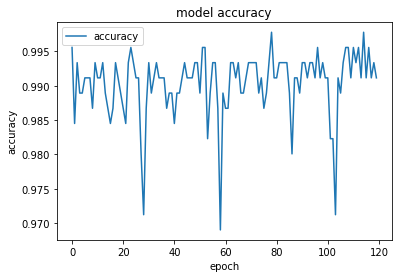

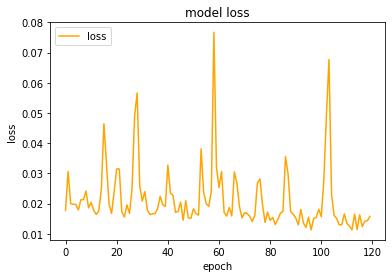

In [24]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'], color='orange')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper left')
plt.show()